In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from torchsummary import summary


from sklearn.model_selection import train_test_split



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

  # location and width parameters
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # width of Gaussian

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10
  
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

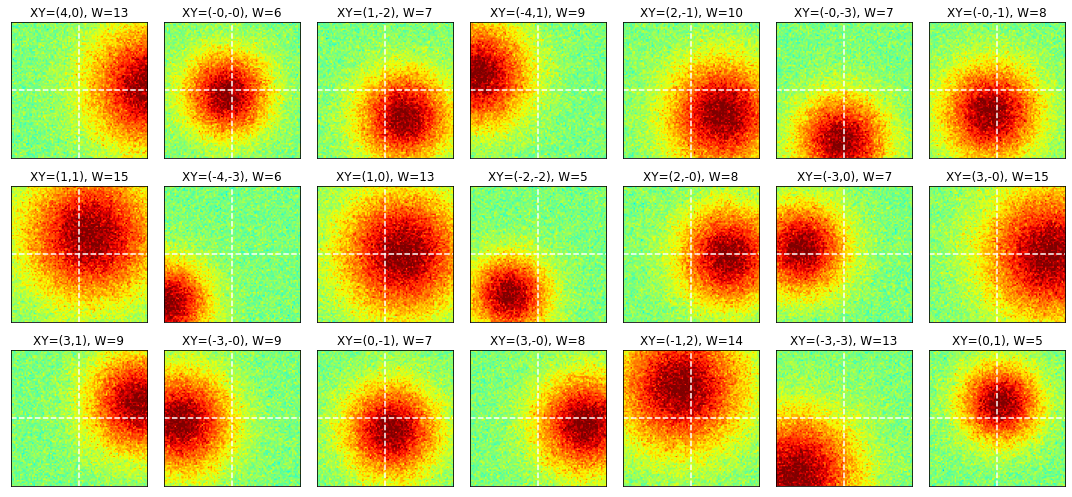

In [3]:
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='top')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [4]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


In [6]:
def makeTheNet():

  class gausnet(nn.Module):

    def __init__(self):
      super().__init__()  

      self.enc = nn.Sequential(
          
          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45
          
          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          
          # linear decision layer
          nn.Flatten(),                # vectorize conv2 block output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,3),             # output size: 3
      )
      


    def forward(self,x):
      return self.enc(x)
  


  net = gausnet()
  
  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)



  return net,lossfun,optimizer
  

In [7]:
net,lossfun,optimizer = makeTheNet()

X,y = iter(train_loader).next()
yHat = net(X)

print(yHat)
print(' ')
print(yHat.shape)

loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[-0.0458, -0.0487, -0.1003],
        [-0.0469, -0.0454, -0.0991],
        [-0.0443, -0.0267, -0.1252],
        [-0.0373, -0.0272, -0.1300],
        [-0.0402, -0.0421, -0.1053],
        [-0.0325, -0.0399, -0.1243],
        [-0.0373, -0.0226, -0.1345],
        [-0.0457, -0.0260, -0.1198],
        [-0.0350, -0.0211, -0.1374],
        [-0.0287, -0.0401, -0.1250],
        [-0.0369, -0.0271, -0.1312],
        [-0.0357, -0.0352, -0.1275],
        [-0.0365, -0.0248, -0.1305],
        [-0.0327, -0.0242, -0.1388],
        [-0.0456, -0.0349, -0.1150],
        [-0.0406, -0.0384, -0.1114]], grad_fn=<AddmmBackward0>)
 
torch.Size([16, 3])
 
Loss:
tensor(39.7776, grad_fn=<MseLossBackward0>)


In [8]:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [9]:
def function2trainTheModel():

  numepochs = 30
  
  net,lossfun,optimizer = makeTheNet()

  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  for epochi in range(numepochs):

    batchLoss = []
    for X,y in train_loader:

      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())


    trainLoss[epochi] = np.mean(batchLoss)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)
      

    testLoss[epochi] = loss.item()



  return trainLoss,testLoss,net
  

In [10]:
trainLoss,testLoss,net = function2trainTheModel()

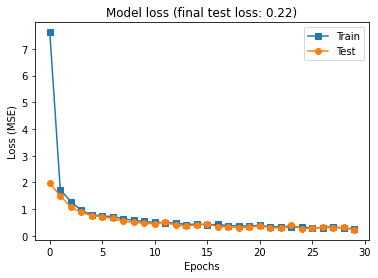

In [11]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title(f'Model loss (final test loss: {testLoss[-1]:.2f})')

plt.show()

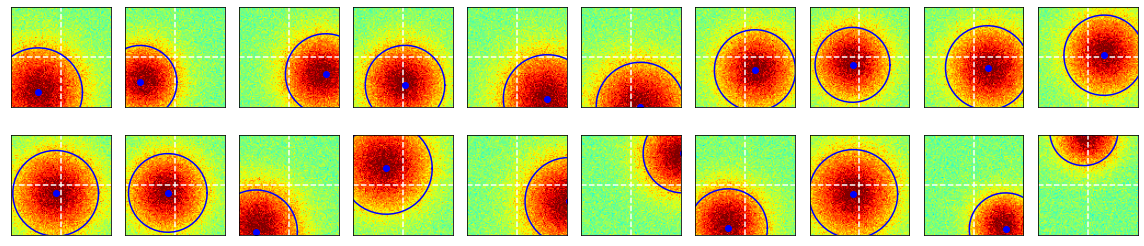

In [12]:
X,Y = next(iter(test_loader))
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')
  
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

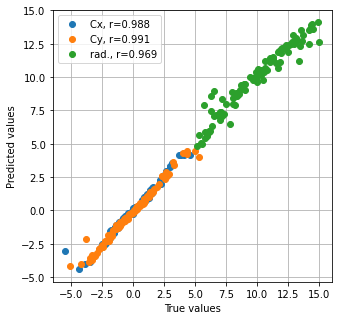

In [13]:
fig = plt.figure(figsize=(5,5))

paramNames = ['Cx','Cy','rad.']

for i in range(3):
  
  # extract parameters and compute correlation
  yy = Y[:,i].detach()
  yh = yHat[:,i].detach()
  cr = np.corrcoef(yy,yh)[0,1]

  plt.plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')


plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()